In [29]:
!pip install datasets

In [30]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

import logging
# Only log error messages
tf.get_logger().setLevel(logging.ERROR)

from datasets import load_dataset

from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, pipeline

import nltk
from nltk.corpus import stopwords
import regex as re
from bs4 import BeautifulSoup

In [31]:
train_dataset = load_dataset('cnn_dailymail', '1.0.0', split='train[:100]')
validation_dataset = load_dataset('cnn_dailymail', '1.0.0', split='validation[:10]')

In [32]:
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

def text_cleaner(text,num):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = re.sub('[m]{2,}', 'mm', newString)
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:                                                 #removing short word
            long_words.append(i)
    return (" ".join(long_words)).strip()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [33]:
tokenizer = AutoTokenizer.from_pretrained('t5-small')

def preprocess_function(dataset):
    inputs = ["summarize: " + text_cleaner(doc,0) for doc in dataset['article']]
    model_inputs = tokenizer(inputs, max_length=1024, truncation=True)

    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            dataset['highlights'], max_length=25, truncation=True
        )

    model_inputs["labels"] = labels["input_ids"]

    return model_inputs

train_tokenized = train_dataset.map(preprocess_function, batched=True)
validation_tokenized = validation_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

In [34]:
model = TFAutoModelForSeq2SeqLM.from_pretrained('t5-small')

All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


In [39]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model, return_tensors='tf')

train = train_tokenized.to_tf_dataset(
    batch_size=8,
    columns=["input_ids", "attention_mask", "labels"],
    shuffle=True,
    collate_fn=data_collator,
)

validation = validation_tokenized.to_tf_dataset(
    batch_size=8,
    columns=["input_ids", "attention_mask", "labels"],
    shuffle=True,
    collate_fn=data_collator,
)

In [40]:
model.compile(optimizer='adam')
history = model.fit(train, epochs=10, validation_data=validation)

Epoch 1/10
13/13 [==============================] - 84s 2s/step - loss: 3.5881 - val_loss: 3.0217
Epoch 2/10
13/13 [==============================] - 7s 557ms/step - loss: 2.4013 - val_loss: 3.2833
Epoch 3/10
13/13 [==============================] - 7s 543ms/step - loss: 1.7523 - val_loss: 3.0769
Epoch 4/10
13/13 [==============================] - 7s 520ms/step - loss: 1.2991 - val_loss: 3.3993
Epoch 5/10
13/13 [==============================] - 7s 548ms/step - loss: 0.9897 - val_loss: 3.7430
Epoch 6/10
13/13 [==============================] - 8s 593ms/step - loss: 0.7146 - val_loss: 3.6418
Epoch 7/10
13/13 [==============================] - 7s 515ms/step - loss: 0.5374 - val_loss: 3.7612
Epoch 8/10
13/13 [==============================] - 7s 552ms/step - loss: 0.4157 - val_loss: 3.5809
Epoch 9/10
13/13 [==============================] - 7s 536ms/step - loss: 0.3071 - val_loss: 4.4670
Epoch 10/10
13/13 [==============================] - 7s 585ms/step - loss: 0.2791 - val_loss: 3.6098


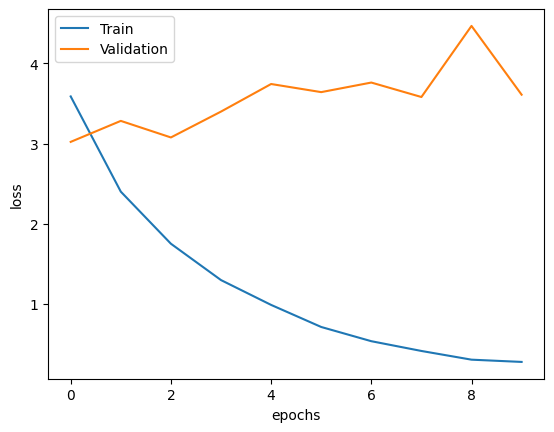

In [43]:
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [46]:
def generate_headline(article_text):
    inputs = tokenizer("summarize: " + article_text, return_tensors="pt", max_length=1024, truncation=True, padding="max_length")
    outputs = model.generate(inputs.input_ids, attention_mask=inputs.attention_mask, max_length=25, num_beams=5, early_stopping=True)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Step 8: Test with a sample article
sample_article = train_dataset[99]['article']
print(sample_article)
headline = generate_headline(sample_article)
print("Generated Headline:", headline)

BAGHDAD, Iraq (CNN) -- None of the 1,000-plus Iraqi detainees freed in recent weeks have broken a pledge not to return to the insurgency, according to the Marine general who oversees the U.S. detention centers in Iraq. A U.S. military panel reviews a detainee's case at Camp Cropper near Baghdad. Speaking in Arabic, Maj. Gen. Doug Stone on Wednesday reassured Iraqis about how the 25,000 detainees -- mostly Sunnis -- are treated after being taken into custody on suspicion of involvement in the insurgency. Stone described the detention system as "open and transparent," saying it makes the detainees better citizens and helps break the cycle of violence and poverty in the country. Stone said detainees get free medical care equal to what he gets as a general, food and water made to Islamic standards, educational opportunities, jobs skills and contact with families. The U.S. detention centers -- at Camp Bucca near the southern port city of Basra and in Camp Cropper near Baghdad -- are politic